In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import ast
from search_space.search_space import VGG8ModelSpaceVGG8
from search_space.util import combine_model_dict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
from hwnas.hw_performance_estimation.hw_performance_estimation import get_hardware_metrics
from evaluator.evaluator import test_epoch, train_epoch, objective
import util
from collections import OrderedDict


In [20]:
df = pd.read_csv("../output_short_training/results_evo.csv", header=None)
df.columns = ["context", "accuracy", "latency", "energy", "area"]

df["metric"] = df.iloc[:,1:5].apply(lambda row: objective(*row, w_acc=100, w_lat=1, w_en=1), axis=1)
df

,context,accuracy,latency,energy,area,metric
0,"{'out_size_conv1': 16, 'kernel_size_conv1': 5,...",0.408381,1.087106e+06,9.866557e+04,1.208983e+08,29.807631
1,"{'out_size_conv1': 16, 'kernel_size_conv1': 5,...",0.391335,1.266034e+06,7.426278e+04,1.122628e+08,28.160306
2,"{'out_size_conv1': 64, 'kernel_size_conv1': 3,...",0.417614,2.837147e+06,1.058518e+06,2.331611e+08,29.283783
3,"{'out_size_conv1': 64, 'kernel_size_conv1': 7,...",0.389915,5.566402e+06,5.536506e+06,1.459416e+09,25.502667
4,"{'out_size_conv1': 32, 'kernel_size_conv1': 7,...",0.578125,2.653740e+06,5.934562e+05,3.281527e+08,45.615253
...,...,...,...,...,...,...
296,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.569602,2.856357e+06,9.159512e+05,4.404154e+08,44.542542
297,"{'out_size_conv1': 32, 'kernel_size_conv1': 7,...",0.479403,2.763921e+06,7.483437e+05,3.972374e+08,35.624714
298,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.603693,2.703188e+06,6.082944e+05,3.367883e+08,48.153328
299,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.459517,2.799260e+06,9.012489e+05,4.231442e+08,33.549817


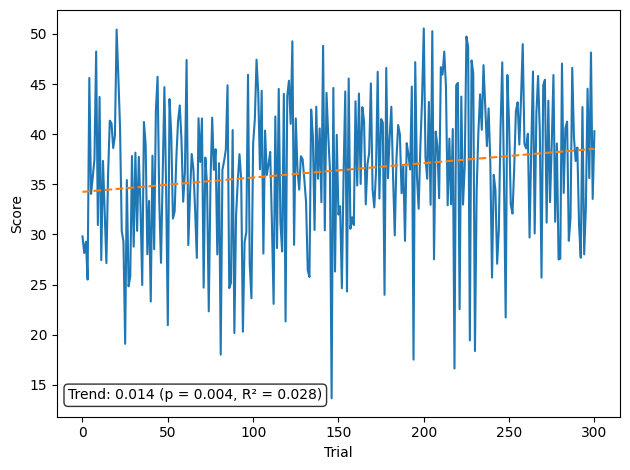

In [21]:
fig, ax = plt.subplots()

# Plot the raw data
ax.plot(df.index, df.metric)
# ax.plot(df.index, df.energy, label='energy')

# Add trend line
df_with_index = df.reset_index()
model = sm.formula.ols(formula='metric ~ index', data=df_with_index)
res = model.fit()
ax.plot(df.index, res.fittedvalues, '--', label='Trend')

# After plotting your data and trendline:
textstr = '\n'.join((
    r'$Slope=%.4f$' % (res.params['index'], ),
    r'$p=%.4f$' % (res.pvalues['index'], ),
    r'$R^2=%.3f$' % (res.rsquared, )))

# Place the text box in the top left (adjust xycoords and position as needed)
# props = dict(boxstyle='round', facecolor='white', alpha=0.8)
# ax.text(0.79, 0.18, textstr, transform=ax.transAxes, fontsize=10,
#         verticalalignment='top', bbox=props)

# plt.show()

# Prepare annotation text
slope = res.params['index']
pval = res.pvalues['index']
r2 = res.rsquared

textstr = f"Trend: {slope:.3f} (p = {pval:.3f}, R² = {r2:.3f})"

# Add text box in the top-left corner of the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.02, 0.07, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)



# ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Score')
plt.tight_layout()
plt.savefig(f"../../Paper/figs/metric_trend.pdf")
plt.show()

In [22]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.663
Date:                Fri, 04 Jul 2025   Prob (F-statistic):            0.00350
Time:                        13:33:02   Log-Likelihood:                -1025.7
No. Observations:                 301   AIC:                             2055.
Df Residuals:                     299   BIC:                             2063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.2533      0.843     40.637      0.0

In [23]:
k = 10
top_k = df.sort_values('metric', ascending=False).head(k)
context_list = top_k['context'].tolist()
state_dicts = [{k: v for k, v in ast.literal_eval(d).items() if k != '__arch__'} for d in context_list]
state_dicts

[{'out_size_conv1': 32,
  'kernel_size_conv1': 5,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 0,
  'kernel_size_conv4': 3,
  'conv6_choice': 1,
  'pool_choice': 1},
 {'out_size_conv1': 16,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 64,
  'kernel_size_conv1': 3,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 1,
  'kernel_size_conv3': 3,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 32,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 3,
  'conv4_choice': 0,
  'kernel_size_conv4': 5

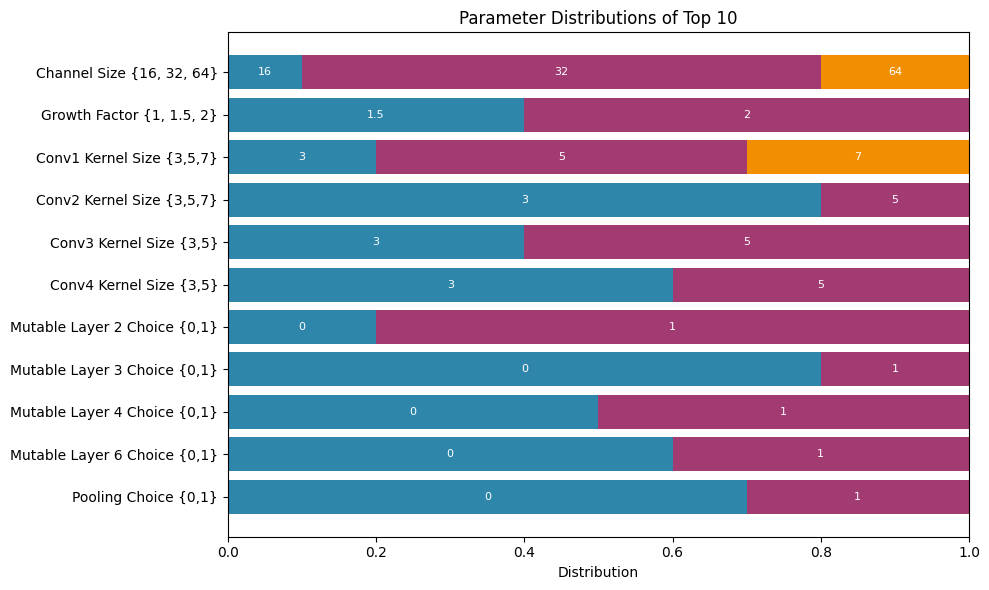

In [24]:
param_options, param_distr = combine_model_dict(state_dicts)

fig, ax = plt.subplots(figsize=(10, 6))


label_rename_map = {
    'pool_choice': 'Pooling Choice {0,1}',
    'conv6_choice': 'Mutable Layer 6 Choice {0,1}',
    'conv4_choice': 'Mutable Layer 4 Choice {0,1}',
    'conv3_choice': 'Mutable Layer 3 Choice {0,1}',
    'conv2_choice': 'Mutable Layer 2 Choice {0,1}',
    'kernel_size_conv4': 'Conv4 Kernel Size {3,5}',
    'kernel_size_conv3': 'Conv3 Kernel Size {3,5}',
    'kernel_size_conv2': 'Conv2 Kernel Size {3,5,7}',
    'kernel_size_conv1': 'Conv1 Kernel Size {3,5,7}' ,
    'channel_multiplier': 'Growth Factor {1, 1.5, 2}',
    'out_size_conv1': 'Channel Size {16, 32, 64}'
}
order = list(label_rename_map.keys())

y_labels = list(param_options.keys())
y_pos = np.arange(len(y_labels))

params_ord = OrderedDict()

for key in order:
    params_ord.update({label_rename_map.get(key) : param_options.get(key)})
max_choices = max(len(v) for v in params_ord.values())
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592A37']
bottom = np.zeros(len(y_labels))


for choice_idx in range(max_choices):
    heights = []
    labels = []
    for key in order:
        param_values = params_ord[label_rename_map[key]]
        param_distribution = param_distr[key]
        if choice_idx < len(param_values):
            heights.append(param_distribution[choice_idx])
            labels.append(f"{param_values[choice_idx]}")
        else:
            heights.append(0)
            labels.append("")
    bars = ax.barh(y_pos, heights, left=bottom, label=f'Value: {labels[0] if labels.count(labels[0]) == len(labels) else f"Option {choice_idx}"}', color=colors[choice_idx % len(colors)],)

    for i, (bar, height, label) in enumerate(zip(bars, heights, labels)):
        # if height > 0.05:  # Only show labels for reasonably sized segments
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + bar.get_height()/2, 
                    label, 
                    ha='center', va='center', 
                    fontsize=8,
                    color='white')

    bottom += heights


ax.set_yticks(y_pos)
ax.set_yticklabels(list(params_ord.keys()))
ax.set_xlabel('Distribution')
ax.set_title(f'Parameter Distributions of Top {k}')
# ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"../../Paper/figs/distribution_top{k}.pdf")
plt.show()


In [25]:
model_space = VGG8ModelSpaceVGG8()

In [26]:
def evaluate_top_model(
    model,
    max_epochs=100,
    batch_size=128,
    num_workers=0,  # for Windows
    patience=15,
    min_delta=1,
    device="cuda",
    lr=0.01
):
    print("Architecture \n", model)
    counter=0
    best_metric=-np.inf
    util.replace_conv_bias_with_bn(module=model, device=device)
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_dataset, val_dataset = random_split(full_train, [45000, 5000])
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    accuracy = 0
    for epoch in range(max_epochs):
        print("Epoch", epoch)
        train_epoch(model, device, train_loader, optimizer)
        accuracy = test_epoch(model, device, val_loader)
        val_metric = accuracy
        if counter >= patience:
            print("Early stopping triggered")
            break
        if val_metric > best_metric + min_delta:
            best_metric = val_metric
            counter = 0
            print("Reset Patience")
        else:
            counter += 1
            
    test_accuracy = test_epoch(model, device, test_loader)
    print(f"Final Test Accuracy Original: {test_accuracy:.2f}")
    print("Training done.")
    acc, lat, eng, area = get_hardware_metrics(model, train_loader=train_loader, test_loader=test_loader, val_loader=val_loader, num_classes=10, sim_config="../MNSIM-2.0/SimConfig.ini")
    final_metric = objective(acc, lat, eng, area)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Latency: {lat:.4f}")
    print(f"Energy: {eng:.4f}")
    print(f"Area: {area:.4f}")
    print(f"Final Metric: {final_metric:.4f}")
    return final_metric, acc, lat, eng, area, accuracy

In [27]:
model = model_space.freeze(state_dicts[0])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_0 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

Architecture 
 VGG8ModelSpaceVGG8(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): DepthwiseSeparableConv(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Identity()
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=512, out_features=10, bias=False)
)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
model = model_space.freeze(state_dicts[1])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_1 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

In [ ]:
model = model_space.freeze(state_dicts[2])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_2 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

In [ ]:
results = []
for i in range(0, 301, 50):
    model = model_space.freeze(state_dicts[i])
    final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    results.append({
        'index': i,
        'final_metric': final_metric,
        'accuracy': acc,
        'latency': lat,
        'energy': eng,
        'area': area,
        "orig_accuracy" : orig_accuracy
    })
df_eval = pd.DataFrame(results)
df

Architecture 
 VGG8ModelSpaceCIFAR10(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): DepthwiseSeparableConv(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Identity()
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=512, out_features=10, bias=False)
)
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


Training:   7%|▋         | 26/352 [00:01<00:19, 16.94it/s]


KeyboardInterrupt: 

In [28]:
df_eval = pd.read_csv("../../df_eval.csv", index_col=0)
df_eval.rename(columns={"index": "trial"}, inplace=True)
df_eval["accuracy"] *= 100
df_eval

,trial,final_metric,accuracy,latency,energy,area,orig_accuracy
0,0,26.327517,37.357955,1.087106e+06,98665.571703,1.208983e+08,83.14
1,50,34.734671,45.596591,1.069842e+06,68014.266402,1.122628e+08,76.78
2,100,24.999451,36.505682,1.339446e+06,239500.023133,2.072543e+08,86.78
3,150,46.906059,58.522727,1.380454e+06,299672.495478,2.504323e+08,85.54
4,200,39.683410,51.917614,2.767785e+06,619543.430703,3.540594e+08,87.54
5,250,52.942141,64.914773,2.258386e+06,415751.079891,2.417967e+08,86.70
6,300,37.529579,49.289773,1.721845e+06,334348.982314,1.727119e+08,80.40


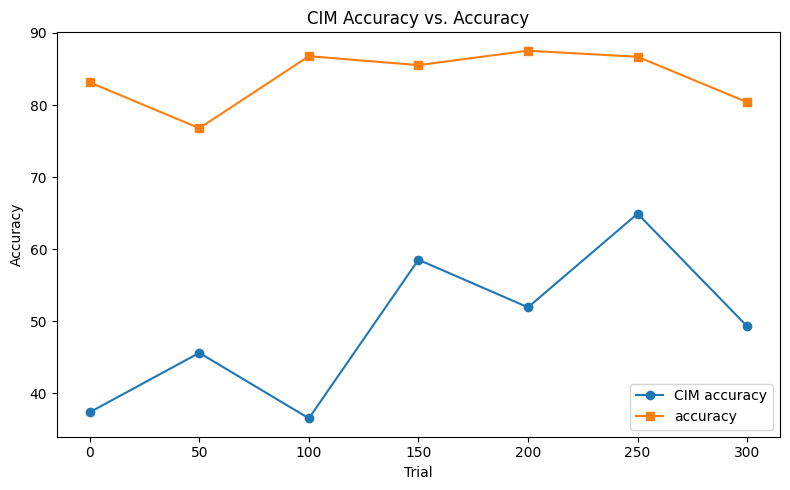

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(df_eval["trial"], df_eval["accuracy"], marker='o', label="CIM accuracy")
plt.plot(df_eval["trial"], df_eval["orig_accuracy"], marker='s', label="accuracy")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title("CIM Accuracy vs. Accuracy")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
control_row_pretrained = {
    "trial": "400",
    "final_metric" : 78.33013044688072,
    "accuracy":  91.69034090909091,
    "latency" : 5151851.44571189,
    "energy" : 4448843.521209403,
    "area" : 1390330993.5429137,
    "orig_accuracy": 93.00426136363636
}

control_row_trained = {
    "trial": "350",
    "final_metric" : 18.102857719607986,
    "accuracy" : 31.46306818181818,
    "latency" : 5151851.44571189,
    "energy" : 4448843.521209403,
    "area" : 1390330993.5429,
    "orig_accuracy" : 54.04829545454546
}

# Append to DataFrame
# df_eval = pd.concat([df_eval, pd.DataFrame([control_row_trained])], ignore_index=True)
# df_eval = pd.concat([df_eval, pd.DataFrame([control_row_pretrained])], ignore_index=True)
# df_eval

In [31]:
import math
31.46306818181818 - math.log(5151851.44571189, 10) - math.log(4448843.521209403, 10)

18.102857719607986

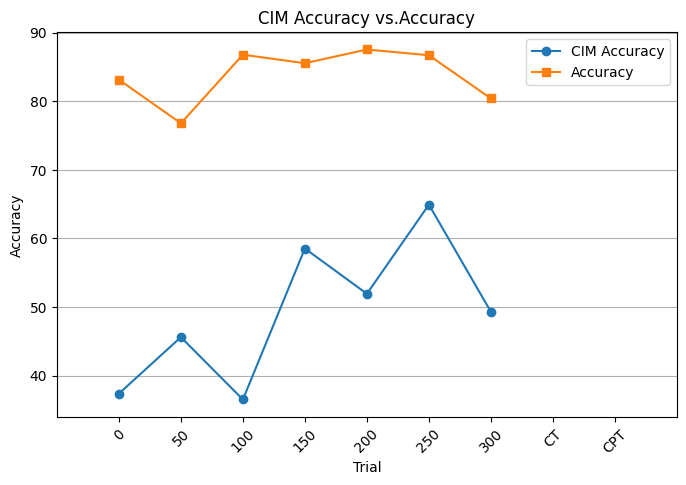

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(df_eval["trial"], df_eval["accuracy"], marker='o', label="CIM Accuracy")
plt.plot(df_eval["trial"], df_eval["orig_accuracy"], marker='s', label="Accuracy")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title("CIM Accuracy vs.Accuracy")
plt.legend()
# plt.grid(True)
# plt.tight_layout()
plt.xlim(left=-1, right=401)
ticks = plt.xticks()[0]
labels = [str(int(t)) if t not in [350, 400] else ("CT" if t == 350 else "CPT") for t in ticks]
plt.xticks(ticks, labels, rotation=45)
ticks = ticks[1:-1]
labels = labels[1:-1]
plt.grid(axis='y')
plt.xticks(ticks, labels)
plt.show()

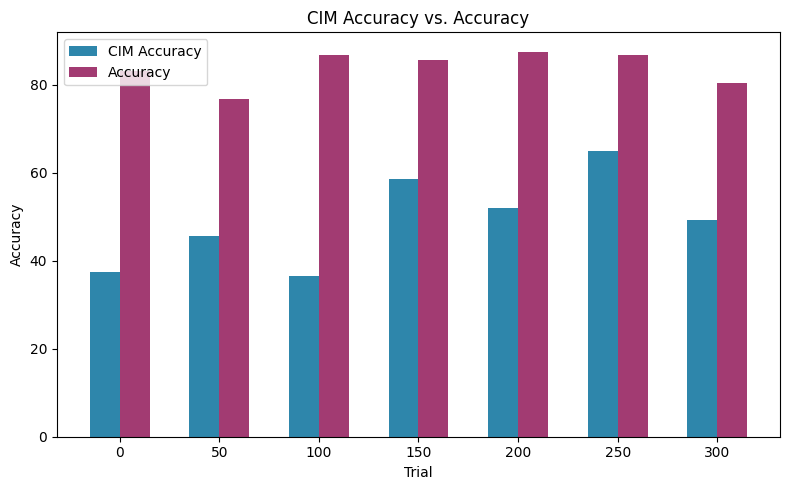

In [33]:
plt.figure(figsize=(8, 5))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592A37']
width = 15  # bar width
trials = df_eval["trial"].astype(int)
plt.bar(trials - width/2, df_eval["accuracy"], width=width, label="CIM Accuracy", color=colors[0])
plt.bar(trials + width/2, df_eval["orig_accuracy"], width=width, label="Accuracy", color=colors[1])



plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title("CIM Accuracy vs. Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("../../Paper/figs/intervall_acc.pdf")
plt.show()


In [34]:
df_eval

,trial,final_metric,accuracy,latency,energy,area,orig_accuracy
0,0,26.327517,37.357955,1.087106e+06,98665.571703,1.208983e+08,83.14
1,50,34.734671,45.596591,1.069842e+06,68014.266402,1.122628e+08,76.78
2,100,24.999451,36.505682,1.339446e+06,239500.023133,2.072543e+08,86.78
3,150,46.906059,58.522727,1.380454e+06,299672.495478,2.504323e+08,85.54
4,200,39.683410,51.917614,2.767785e+06,619543.430703,3.540594e+08,87.54
5,250,52.942141,64.914773,2.258386e+06,415751.079891,2.417967e+08,86.70
6,300,37.529579,49.289773,1.721845e+06,334348.982314,1.727119e+08,80.40


In [35]:
diff = df_eval["orig_accuracy"] - df_eval["accuracy"]

<Axes: >

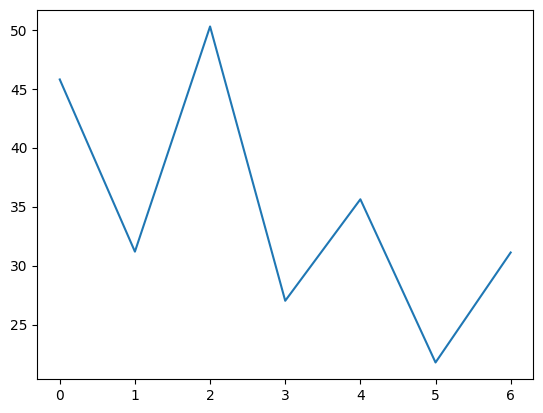

In [36]:
diff.plot()

In [37]:
# Create index as independent variable
X = pd.Series(diff.index, name="x")
X = sm.add_constant(X)  # adds intercept term
y = diff

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     2.659
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.164
Time:                        13:34:23   Log-Likelihood:                -24.118
No. Observations:                   7   AIC:                             52.24
Df Residuals:                       5   BIC:                             52.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.9818      6.117      7.026      0.0

/home/luis/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [38]:
X = pd.Series(df_eval["trial"], name="trial")
X = sm.add_constant(X)  # adds intercept term
y = df_eval["accuracy"]

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     3.924
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.104
Time:                        13:34:24   Log-Likelihood:                -23.794
No. Observations:                   7   AIC:                             51.59
Df Residuals:                       5   BIC:                             51.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5318      5.840      6.769      0.0

/home/luis/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
